<a href="https://colab.research.google.com/github/p1000ratte0712-design/lotto2/blob/main/keras_lstm_lotto_968.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 로또 번호 예측

- 딥러닝 로또 예측 번호 확인: https://animalface.site/lotto

- 동영상 설명: 유튜브 조코딩 채널(https://www.youtube.com/channel/UCQNE2JmbasNYbjGAcuBiRRg)

- 참고 문헌: 김태영님 블로그(https://tykimos.github.io/2020/01/25/keras_lstm_lotto_v895/)

In [20]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-rc1
!pip install 'h5py==2.10.0' --force-reinstall

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1
  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (

In [21]:
import numpy as np

rows = np.loadtxt("./lotto.csv", delimiter=",")
row_count = len(rows)
print(row_count)

591


In [22]:
import numpy as np

# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌

    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []

    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)

    return numbers

In [23]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
numbers
X[0]: [2, 16, 19, 31, 34, 35]
Y[0]: [13, 14, 22, 27, 30, 38]


In [27]:
train_idx = (0, 420)
val_idx = (421, 500)
test_idx = (501, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 420), val: (421, 500), test: (501, 590)


In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.Input(shape=(1, 45), batch_size=1),
    keras.layers.LSTM(128, return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    batch_train_loss = []
    batch_train_acc = []

    for i in range(train_idx[0], train_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)

        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함

        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch    0 train acc 0.018 loss 0.465 val acc 0.026 loss 0.416
epoch    1 train acc 0.021 loss 0.410 val acc 0.024 loss 0.406
epoch    2 train acc 0.024 loss 0.404 val acc 0.025 loss 0.402
epoch    3 train acc 0.025 loss 0.401 val acc 0.026 loss 0.400
epoch    4 train acc 0.026 loss 0.399 val acc 0.028 loss 0.398
epoch    5 train acc 0.030 loss 0.396 val acc 0.032 loss 0.396
epoch    6 train acc 0.034 loss 0.394 val acc 0.036 loss 0.393
epoch    7 train acc 0.037 loss 0.392 val acc 0.039 loss 0.391
epoch    8 train acc 0.040 loss 0.390 val acc 0.042 loss 0.389
epoch    9 train acc 0.043 loss 0.387 val acc 0.045 loss 0.386
epoch   10 train acc 0.046 loss 0.385 val acc 0.048 loss 0.384
epoch   11 train acc 0.050 loss 0.382 val acc 0.052 loss 0.381
epoch   12 train acc 0.053 loss 0.380 val acc 0.055 loss 0.378
epoch   13 train acc 0.057 loss 0.377 val acc 0.058 loss 0.376
epoch   14 train acc 0.060 loss 0.374 val acc 0.061 loss 0.373
epoch   15 train acc 0.063 loss 0.371 val acc 0.065 los

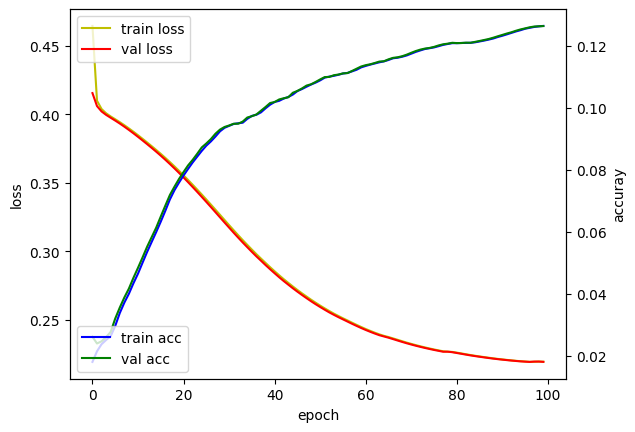

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [57]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)

[np.float64(2347115130.178571), np.float64(56526861.35515873), np.float64(1452179.974206349), np.float64(50000.0), np.float64(5000.0)]


In [58]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [59]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:

        if len(selected_balls) == 6:
            break

        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [62]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

for layer in model.layers:
    if hasattr(layer, 'reset_states'):
        layer.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음

    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])

        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers)

        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1

    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)

    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total')
print('==========')
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   0   0   0   0   1   9           5,000
[   2]   0   0   0   0   0  10               0
[   3]   0   0   0   0   0  10               0
[   4]   0   0   0   0   0  10               0
[   5]   0   0   0   0   0  10               0
[   6]   0   0   0   0   0  10               0
[   7]   0   0   0   0   0  10               0
[   8]   0   0   0   0   0  10               0
[   9]   0   0   0   0   0  10               0
[  10]   0   0   0   0   0  10               0
[  11]   0   0   0   0   0  10               0
[  12]   0   0   0   0   0  10               0
[  13]   0   0   0   0   0  10               0
[  14]   0   0   0   0   0  10               0
[  15]   0   0   0   0   0  10               0
[  16]   0   0   0   0   1   9           5,000
[  17]   0   0   0   0   1   9           5,000
[  18]   0   0   0   0   1   9           5,000
[  19]   0   0   0   0   0  10               0
[  20]   0   0   0   0   0  10               0
[  21]   0   0   0   

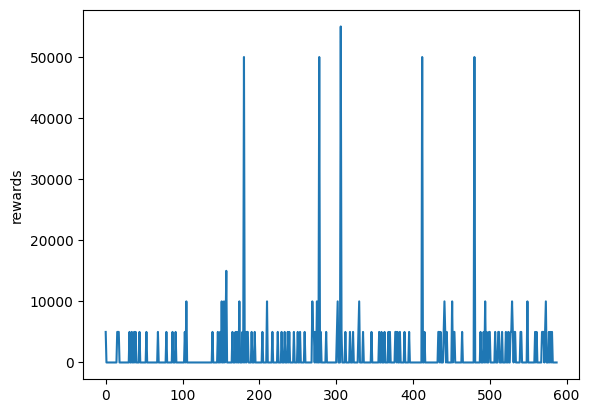

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

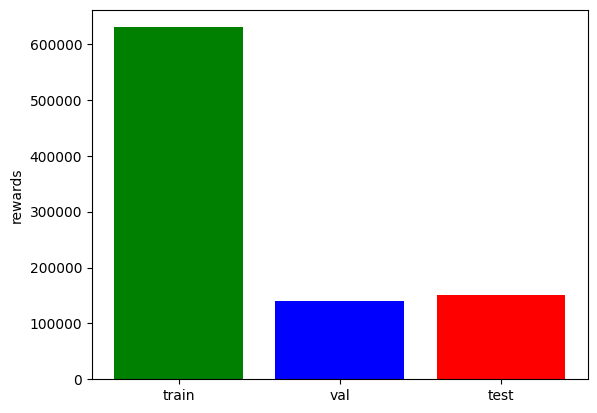

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

In [66]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    batch_train_loss = []
    batch_train_acc = []

    for i in range(len(x_samples)):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    # Note: This cell only performs training, not validation.
    # If you want to include validation, you should add a loop similar to the training loop,
    # using model.test_on_batch and the validation dataset (val_idx).

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))

epoch    0 train acc 0.020 loss 0.453
epoch    1 train acc 0.030 loss 0.408
epoch    2 train acc 0.031 loss 0.403
epoch    3 train acc 0.034 loss 0.400
epoch    4 train acc 0.036 loss 0.398
epoch    5 train acc 0.036 loss 0.395
epoch    6 train acc 0.038 loss 0.393
epoch    7 train acc 0.039 loss 0.390
epoch    8 train acc 0.040 loss 0.387
epoch    9 train acc 0.043 loss 0.384
epoch   10 train acc 0.046 loss 0.381
epoch   11 train acc 0.049 loss 0.377
epoch   12 train acc 0.053 loss 0.374
epoch   13 train acc 0.057 loss 0.370
epoch   14 train acc 0.060 loss 0.367
epoch   15 train acc 0.063 loss 0.363
epoch   16 train acc 0.067 loss 0.359
epoch   17 train acc 0.070 loss 0.355
epoch   18 train acc 0.073 loss 0.351
epoch   19 train acc 0.076 loss 0.346
epoch   20 train acc 0.078 loss 0.342
epoch   21 train acc 0.081 loss 0.338
epoch   22 train acc 0.083 loss 0.333
epoch   23 train acc 0.085 loss 0.328
epoch   24 train acc 0.088 loss 0.324
epoch   25 train acc 0.091 loss 0.319
epoch   26 t

In [67]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [np.int64(3), np.int64(16), np.int64(18), np.int64(19), np.int64(40), np.int64(41)]
1 : [np.int64(10), np.int64(19), np.int64(28), np.int64(33), np.int64(40), np.int64(41)]
2 : [np.int64(19), np.int64(22), np.int64(34), np.int64(40), np.int64(41), np.int64(45)]
3 : [np.int64(19), np.int64(21), np.int64(25), np.int64(33), np.int64(40), np.int64(41)]
4 : [np.int64(10), np.int64(19), np.int64(33), np.int64(40), np.int64(41), np.int64(43)]
5 : [np.int64(10), np.int64(19), np.int64(32), np.int64(40), np.int64(41), np.int64(43)]
6 : [np.int64(19), np.int64(31), np.int64(34), np.int64(39), np.int64(40), np.int64(41)]
7 : [np.int64(3), np.int64(27), np.int64(30), np.int64(40), np.int64(41), np.int64(43)]
8 : [np.int64(10), np.int64(19), np.int64(22), np.int64(33), np.int64(40), np.int64(41)]
9 : [np.int64(1), np.int64(19), np.int64(22), np.int64(33), np.int64(40), np.int64(41)]


- 딥러닝 로또 예측 번호 확인: https://animalface.site/lotto

- 동영상 설명: 유튜브 조코딩 채널(https://www.youtube.com/channel/UCQNE2JmbasNYbjGAcuBiRRg)

- 참고 문헌: 김태영님 블로그(https://tykimos.github.io/2020/01/25/keras_lstm_lotto_v895/)